## Geospatial Demo with `geopandas`  - BC Surficial Geology/Oil & Gas Activity

We will work with the `geopandas` library and some public data from the BC government to examine the surficial geology in the Fort St. John area of British Columbia. You might consider the surficial geology for drilling issues like lost circulation while drilling surface hole, as we usually don't sample the bedrock or log the surface hole portion of a well with geophysical well logs. With that in mind, we'll bring in surface locations of BC oil and gas wells to compare against the surficial geology. I'll also sort the wells by major operators using some standard `pandas` data filtering operations that also work on `geodataframes`.

### Datasets used in this notebook:

- [BC Digital Geology](https://www2.gov.bc.ca/gov/content/industry/mineral-exploration-mining/british-columbia-geological-survey/geology/bcdigitalgeology) (downloadable as `.gpkg` file)
- [BC oil and gas wells - permitted surface locations](https://data-bcogc.opendata.arcgis.com/datasets/9149cb556e694617970a5774621af8be_0?geometry=-121.472%2C55.987%2C-120.165%2C56.121&orderBy=OPERATOR_ABBREVIATION&where=OPERATOR_ABBREVIATION%20%3D%20%27CNRL%27) (downloadable as zipped `.shp` file)

### Steps taken:

1. Importing the datasets using `geopandas` `read_file()` method
2. Reprojecting the datasets to a common coordinate reference system using `to_crs()` method
2. Coordinate indexing the geodataframes to create map in our area of interest using the coordinate indexer `.cx` property
3. Performing some very simple `regex` text replacements on the geodataframe to correct some operator names
4. Plot our well data sorted by operator using the surficial geology as a baselayer

First, import packages:

In [2]:
import geopandas as gpd
import mapclassify as mc
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

## Importing data

Let's import the BC digital geology (`.gpkg` file) as a `geodataframe`, simple using the `read_file()` method. We're also going to make use of the `os` module to change working directories using `os.chdir()` so we can grab the files we need. We can also inspect the header to get a quick look at the data: 

In [4]:
os.chdir('./data/BC_digital_geology_gpkg/')
fname = 'BC_digital_geology.gpkg'

bc_bedrock = gpd.read_file(fname)

bc_bedrock.head()

,upid,area_m2,strat_unit,era,period,strat_age,strat_name,gp_suite,fm_lithodm,mem_phase,...,belt,terrane,basin,basin_age,project,src_ref,src_url,map_comp,edit_date,geometry
0,c5c2489e,2313841.0,uPrMgs,Proterozoic,Neoproterozoic,Neoproterozoic,Misinchinka Group,Misinchinka Group,None,None,...,Foreland,North America - basinal strata,None,None,Northeast,"MacIntyre, D.G., Legun, A., Bellefontaine, K. ...",http://cmscontent.nrs.gov.bc.ca/geoscience/Pub...,"Massey et al., 2005, BC",2019-12-19,"POLYGON ((-124.93253 56.97049, -124.93478 56.9..."
1,ac4fbe3b,3830363.0,uPrMCm,Proterozoic,Neoproterozoic,Neoproterozoic,Mica Creek Succession,Mica Creek Succession,None,None,...,Foreland,North America - basinal strata,None,None,Kootenay,"Höy, T., Church, B.N., Legun, A., Glover, K., ...",http://cmscontent.nrs.gov.bc.ca/geoscience/Pub...,"Massey et al., 2005, BC",2019-12-19,"POLYGON ((-118.34829 52.09515, -118.34377 52.0..."
2,4aef1024,56727919.0,uPrpg,Proterozoic,Neoproterozoic,Neoproterozoic,,None,None,None,...,Omineca,Cassiar,None,None,QUEST,"Logan, J.M. Schiarizza, P., Struik, L.C., Barn...",http://cmscontent.nrs.gov.bc.ca/geoscience/Pub...,"Logan et al., 2010, QUEST",2019-12-19,"POLYGON ((-123.78600 55.39854, -123.83131 55.4..."
3,769a268f,79742830.0,uPrM,Proterozoic,Neoproterozoic,Neoproterozoic,Misinchinka Group,Misinchinka Group,None,None,...,Foreland,North America - basinal strata,None,None,QUEST,"Logan, J.M. Schiarizza, P., Struik, L.C., Barn...",http://cmscontent.nrs.gov.bc.ca/geoscience/Pub...,"Logan et al., 2010, QUEST",2019-12-19,"POLYGON ((-122.79884 54.99805, -122.80640 55.0..."
4,e4db376c,749257367.0,uPrpg,Proterozoic,Neoproterozoic,Neoproterozoic,,None,None,None,...,Omineca,Cassiar,None,None,QUEST,"Logan, J.M. Schiarizza, P., Struik, L.C., Barn...",http://cmscontent.nrs.gov.bc.ca/geoscience/Pub...,"Logan et al., 2010, QUEST",2019-12-19,"POLYGON ((-124.03004 55.75736, -124.03679 55.7..."


Change the working directory and load the BC well surface locations shapefile to a `geodataframe`. Let's also inspect the header on this file:

In [12]:
os.chdir('..')
os.chdir('./data/')
fname = 'Well_Surface_Hole_Locations__Permitted_-shp.zip'

wells = gpd.read_file('zip:' + fname)

wells.head()

,OBJECTID,WELL_AUTHO,OPERATOR_A,OPERATOR_1,WELL_SURFA,WELL_AREA_,OPTIONAL_W,WELL_NAME_,WELL_NAME,WELL_ACTIV,BORE_FLUID,OPERATION_,STATUS_EFF,WELL_AUT_1,CONFIDENTI,geometry
0,50019140,00001,ROYAL,None,D- 080-H/092-G-03,CITY NO. 1,None,1948-06-10,ROYAL CITY NO. 1 D- 080-H/092-G-03,ABAN,UND,UND,1948-12-11,1948-06-10,N,POINT (1210659.538 463377.729)
1,50019141,00002,CANADIAN,None,B- 050-D/082-G-01,KOOTENAY NO. 1,None,1949-09-03,CANADIAN KOOTENAY NO. 1 B- 050-D/082-G-01,ABAN,UND,UND,1950-07-26,1949-09-03,N,POINT (1838376.866 514817.954)
2,50019142,00003,BORDER OILS,None,D- 055-A/082-G-02,NO. 1,None,1948-07-04,BORDER OILS NO. 1 D- 055-A/082-G-02,ABAN,UND,UND,1949-07-25,1948-07-05,N,POINT (1834086.813 515529.778)
3,50019143,00004,CANLIN,None,13-11-081-17,PINGEL,None,2017-12-06,CANLIN PINGEL 13-11-081-17,ABAN,GAS,UND,1990-06-29,1949-08-06,N,POINT (1338513.849 1237273.520)
4,50019144,00005,CVE ENERGY,ET AL,A- 065-E/093-I-16,LONE MOUNTAIN NO. 1,None,2018-06-07,CVE ENERGY ET AL LONE MOUNTAIN NO. 1 A- 065-E...,ABAN,UND,UND,1950-08-13,1949-10-24,N,POINT (1356062.883 1112487.170)


## Reprojecting data

The well data is projected using the BC Albers grid ([EPSG 3005](https://spatialreference.org/ref/epsg/nad83-bc-albers/)). We can check this with using `wells.crs`. Let's also check the CRS of the geology data:

In [4]:
print(wells.crs)
print(bc_bedrock.crs)

{'init': 'epsg:3005'}
{'init': 'epsg:4326'}


 Reproject the wells to degrees lat/lon by using the geopandas `to_crs()` method, in this case, the digital geology map uses [EPSG 4326](https://spatialreference.org/ref/epsg/wgs-84/) spatial reference, so we will use that EPSG code to reproject the data. Since this is a fairly large map, this should be sufficient for the purposes of this demonstration.

In [5]:
wells_proj = wells.to_crs(epsg=4326)

We can now plot the bedrock geology and the well locations on the same map.

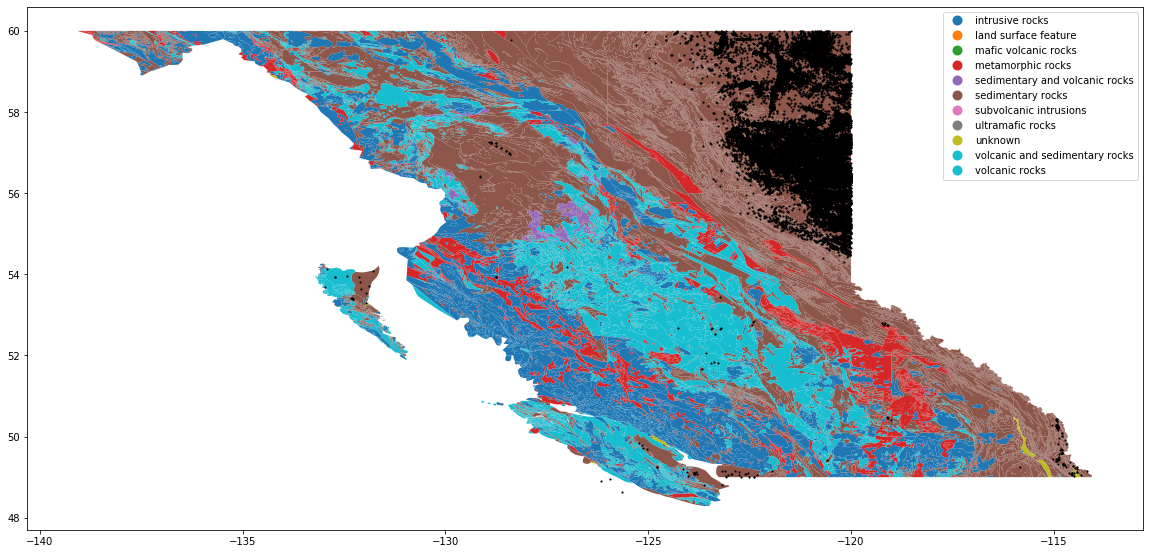

In [6]:
base = bc_bedrock.plot(column = 'rock_class', figsize=(20,20), legend=True)
wells_proj.plot(ax=base, marker=".", markersize=5, color="black")

## Narrowing down area of interest

This map is a bit too big for us to work with. I'd like to focus on the area of northeast BC with the oil and gas activity, the dense cluster of black dots (wells) up in the top-right corner of the province. Let's slice the geodataframes and store them as new datasets using the `.cx` coordinate-indexer to narrow our area of interest:

In [7]:
nebc_bedrock = bc_bedrock.cx[-125:-120,54:60]
nebc_wells = wells_proj.cx[-125:-120,54:60]

Replot the data. We'll need to set y and x limits to the map since the geology polygons extend out past the well limits.

(-125, -120)

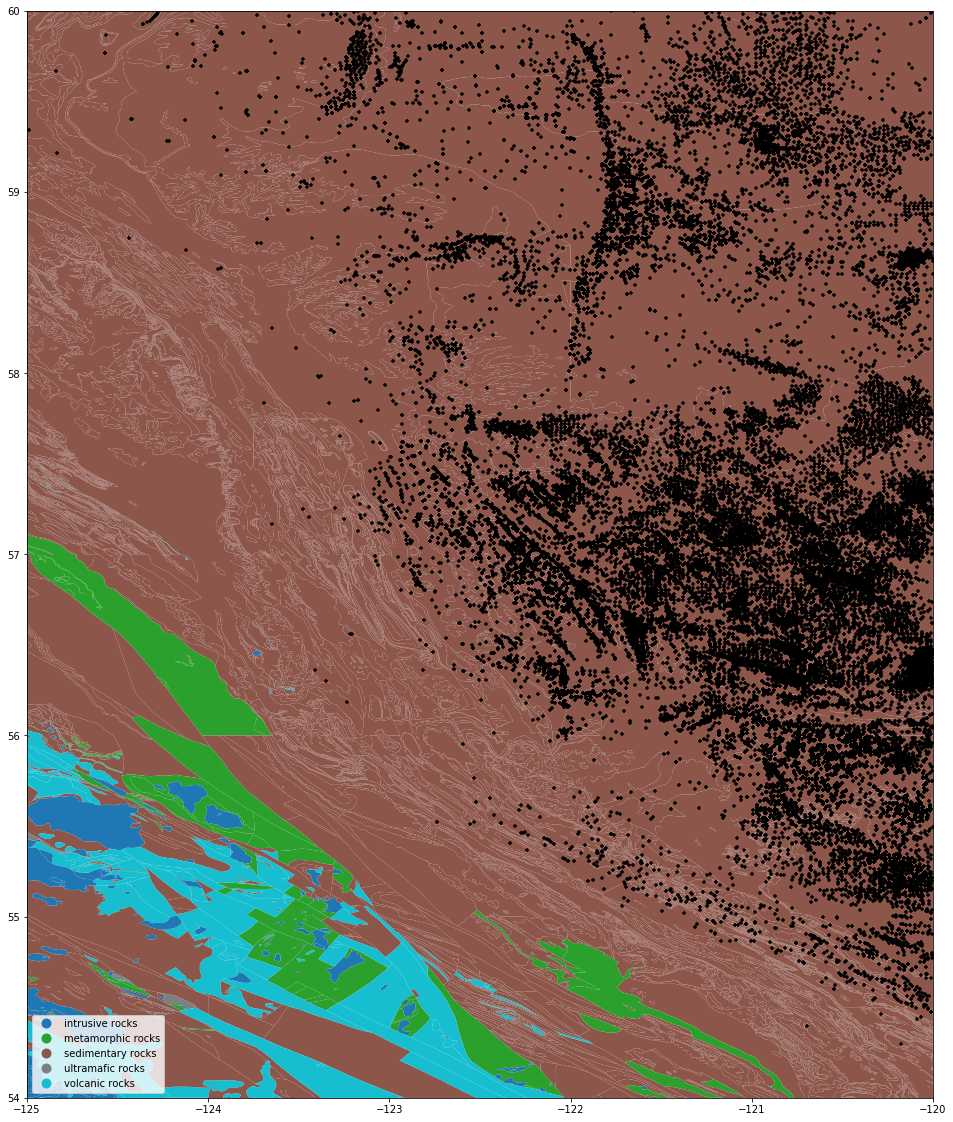

In [8]:
base = nebc_bedrock.plot(column = 'rock_class', figsize=(20,20), legend=True)
nebc_wells.plot(ax=base, marker="+", markersize=10, color="black")

base.set_ylim(54,60)
base.set_xlim(-125,-120)

This is still too big. Let's slice again and try to capture the regional heritage area in BC, which is a fairly active area for unconventional liquids rich gas. Since we know the bedrock geology is all sedimentary rocks in this area, we can also colour the geology polygons using the `rock_type` column instead of `rock_class` to get more specific about the lithology:

In [9]:
hertg_bedrock = nebc_bedrock.cx[-121.5:-120,55:56.2]
hertg_wells = nebc_wells.cx[-121.5:-120,55:56.2]

(-121.5, -120)

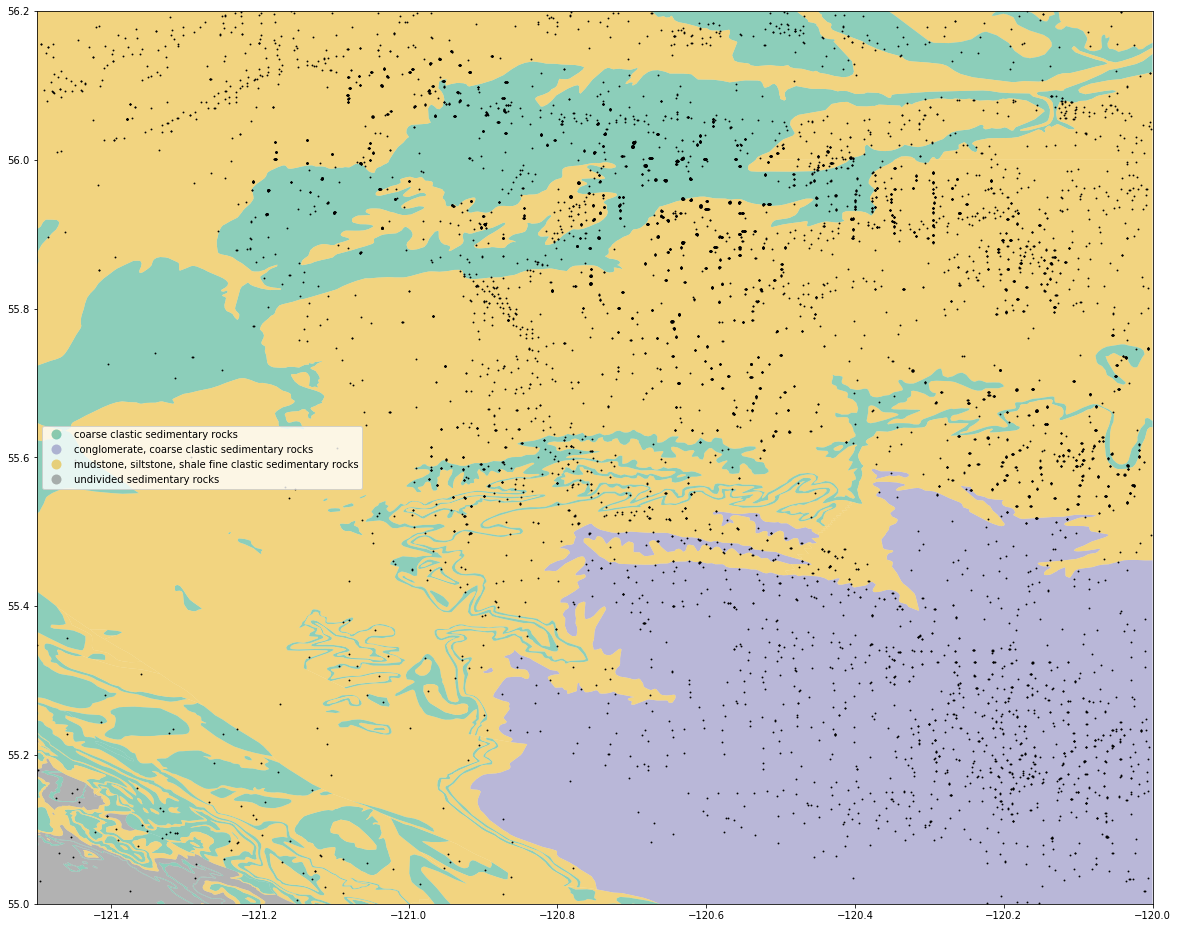

In [19]:
base = hertg_bedrock.plot(column = 'rock_type', figsize=(20,20), alpha= 0.5, legend=True, cmap="Dark2")
hertg_wells.plot(ax=base, color='black', marker=".", markersize=3, legend=True)
base.set_ylim(55,56.2)
base.set_xlim(-121.5,-120)

## Colour wells by operator

We're definitely getting close with this map, but I would like to see the wells of some different operators picked out with different colours. Let's say I'm interested in **CNRL** wells first.

I'd like to see **CNRL** wells plotted in a different color, but there are two **CNRL** operator entries, **"CNRES"**, and **"CNRL"**, we'll write a some regex to correct that. Then we can create a new column called `'Operator'` using `.replace` method on the `'OPERATOR_A'` column and passing in the regex replacements `dict` object:

In [11]:
replacements = {
    r'CNRES': 'CNRL', #change CNRES to CNRL
}

hertg_wells['Operator'] = hertg_wells['OPERATOR_A'].replace(regex=replacements)

C:\anaconda\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


Grab the **CNRL** wells, while we're at it, let's grab some of the major Montney players as well and store them as separate `geodataframes`, normally we would spend more time checking the unique values in the operator column and clean them using regex, but this will do for our purposes right now:

In [12]:
cnrl_wells = hertg_wells[hertg_wells['Operator']=="CNRL"]
ovintiv_wells = hertg_wells[hertg_wells['Operator']=="OVV"]
arc_wells = hertg_wells[hertg_wells['Operator']=="ARCRES"]
crew_wells = hertg_wells[hertg_wells['Operator']=="CREW"]
tourmaline_wells = hertg_wells[hertg_wells['Operator']=="TOURMALINE"]
shell_wells = hertg_wells[hertg_wells['Operator']=="SHELL"]

Plot our final map below, we'll plot the **CNRL** wells as red crosses. We'll plot other operators with different colors and keep them as small dots. Let's also give the map a title and move the geology legend out of the way:

Text(0.5, 1, 'Bedrock Geology with O&G Wells - Regional Heritage Area, NEBC')

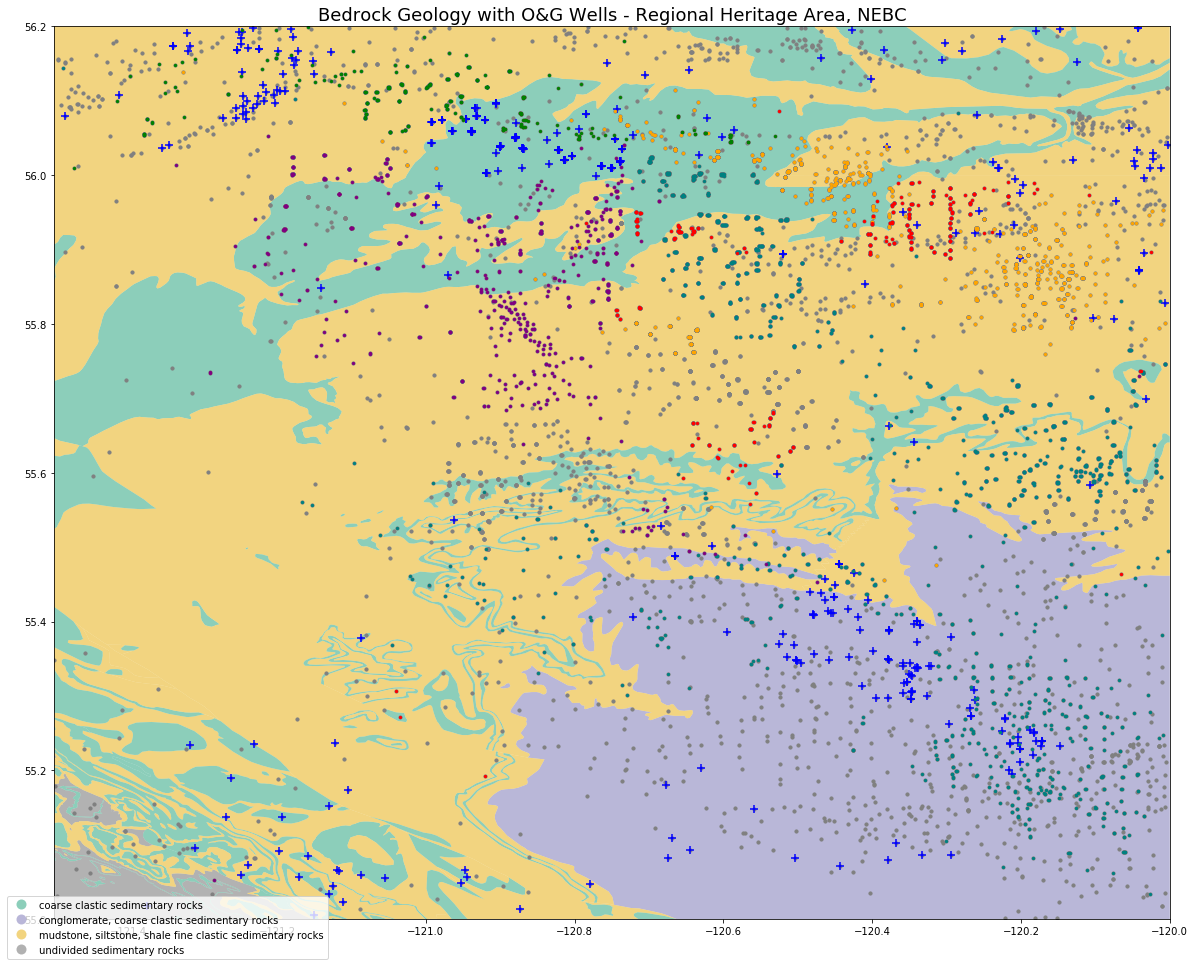

In [25]:
fig, base = plt.subplots(figsize=(20,20))

hertg_bedrock.plot(ax=base, column = 'rock_type', legend=True, alpha=0.5,cmap='Dark2')

leg = base.get_legend()
leg.set_bbox_to_anchor((0.05, -0.05, 0.2, 0.2))

hertg_wells.plot(ax=base, color='grey', marker="o", markersize=10)
cnrl_wells.plot(ax=base, color='blue', marker='+', markersize=50)
ovintiv_wells.plot(ax=base, color='teal', marker='.', markersize=20)
arc_wells.plot(ax=base, color='orange', marker='.', markersize=20)
crew_wells.plot(ax=base, color='green', marker='.', markersize=20)
tourmaline_wells.plot(ax=base, color='red', marker='.', markersize=20)
shell_wells.plot(ax=base, color='purple', marker='.', markersize=20)

base.set_ylim(55,56.2)
base.set_xlim(-121.5,-120)
base.set_title("Bedrock Geology with O&G Wells - Regional Heritage Area, NEBC", fontdict={'fontsize':18})